In [ ]:
!git clone https://github.com/public-ai/Image-Classification-models.git

In [41]:
%matplotlib inline
import sys
import os

import shutil
import matplotlib.pyplot as plt
sys.path.append("./Image-Classification-models/")
sys.path.append("../")
from dataset import Dataset
from models import Alexnet, VGGNet
from tqdm import tqdm
import tensorflow as tf
import tensorboardcolab

import cv2
import numpy as np

## Graph Visualization

In [42]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


## Load DataSet

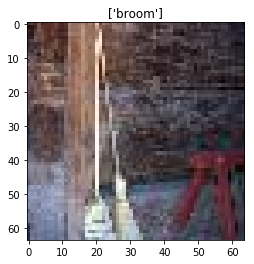

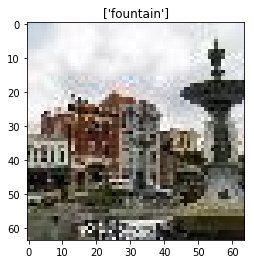

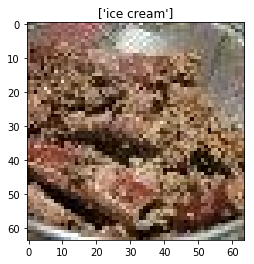

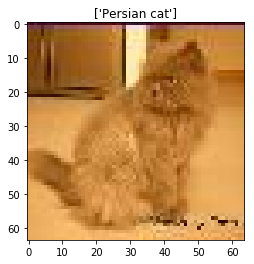

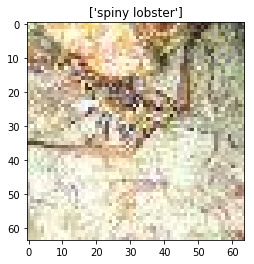

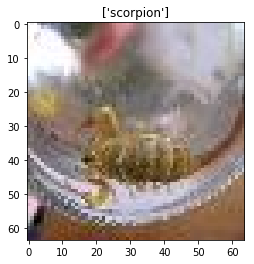

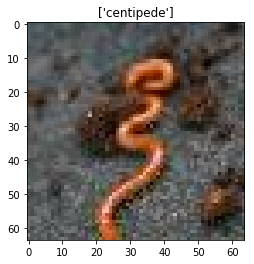

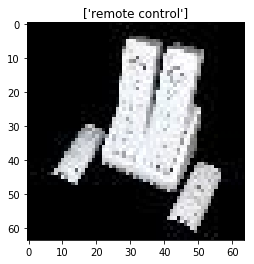

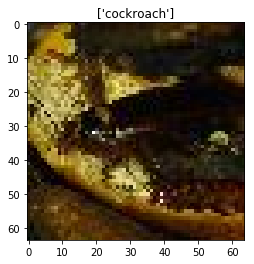

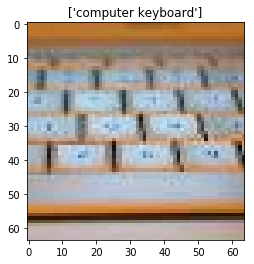

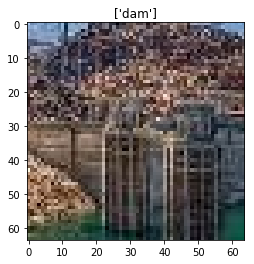

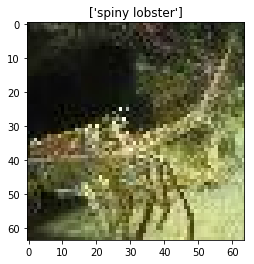

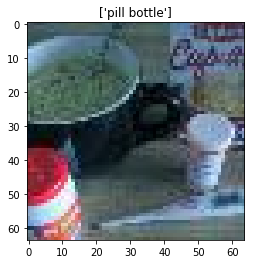

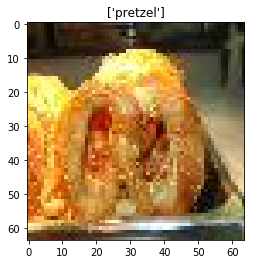

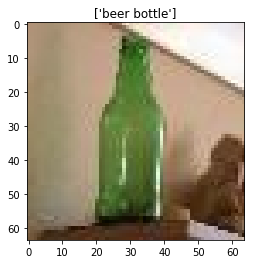

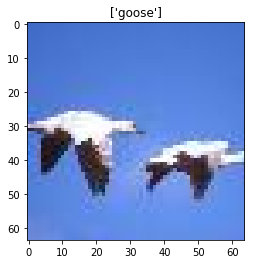

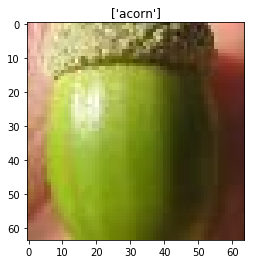

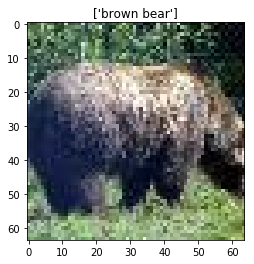

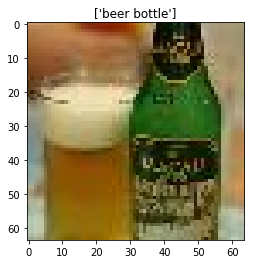

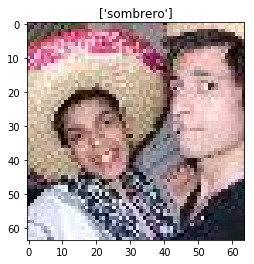

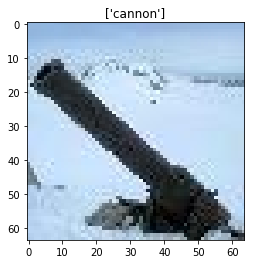

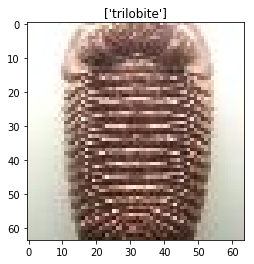

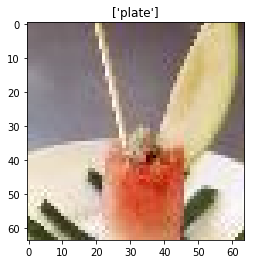

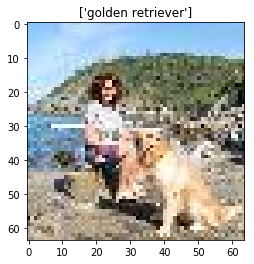

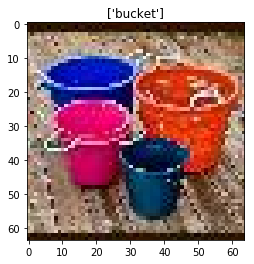

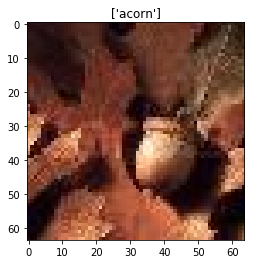

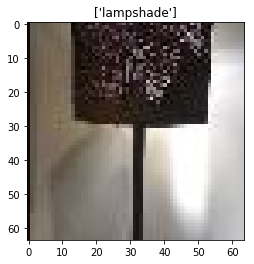

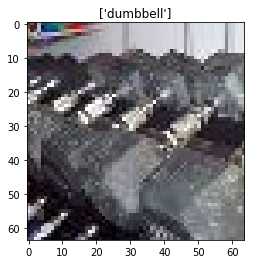

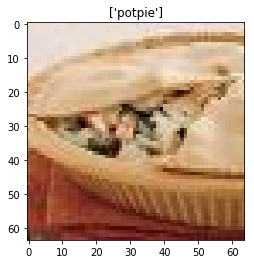

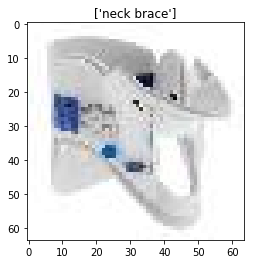

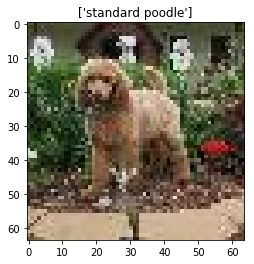

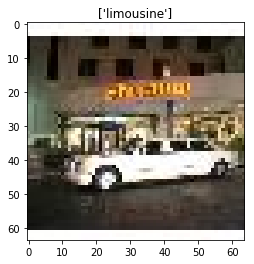

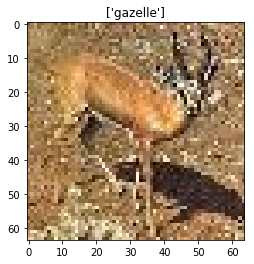

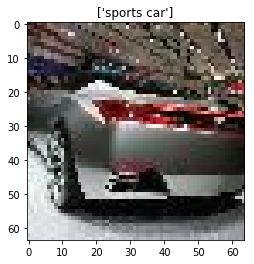

KeyboardInterrupt: 

In [43]:
trainset = Dataset('train')

num_classes = trainset.num_classes
num_data = trainset.num_data

images, labels = trainset[:64]

for image, label in zip(images,labels):
    plt.title(trainset.label2name(label))
    plt.imshow(image)
    plt.show()

## Building Model

In [44]:
net = VGGNet()
(net._initialize_placeholders()
._attach_inference_network()
._attach_loss_network()
._attach_metric_network()
._attach_summary_network()
._attach_optimizer_network())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [45]:
show_graph(net.graph)

## TRAINING MODELS

In [ ]:
# LOG PATH Setting
LOG_DIR = "./log"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

tbc = tensorboardcolab.TensorBoardColab(graph_path=LOG_DIR)

train_writer = tf.summary.FileWriter(LOG_DIR+"/train", net.graph)
test_writer = tf.summary.FileWriter(LOG_DIR+"/test")
merged = net.graph.get_collection(tf.GraphKeys.SUMMARY_OP)[0] # Summary operation 가져오기

In [ ]:
# 변수 초기화 및 Operation 가져오기
net.initialize_variables() # 변수 초기화

graph = net.graph

x = graph.get_tensor_by_name('X:0')
labels = graph.get_tensor_by_name('labels:0')
is_train = graph.get_tensor_by_name('is_train:0')
lr = graph.get_tensor_by_name('learning_rate:0')

top_5 = graph.get_tensor_by_name('top_5_accuracy:0')
top_1 = graph.get_tensor_by_name('top_1_accuracy:0')
loss = graph.get_tensor_by_name('loss:0')

train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]
global_step = graph.get_collection(tf.GraphKeys.GLOBAL_STEP)[0]

metric_init_op, metric_update_op = graph.get_collection('metric_ops')

In [13]:
def random_crop(images, shape=(56,56,3)):
    """
    shape 크기만큼 이미지 내에서 무작위로 잘라오는 메소드
    
    """
    _, h, w, _ = images.shape
    max_h = h-shape[0]
    max_w = w-shape[1]
    
    crops = []
    for idx, image in enumerate(images):
        start_h = np.random.randint(0,max_h)
        start_w = np.random.randint(0,max_w)
        cropped = image[start_h:start_h+shape[0],
                        start_w:start_w+shape[1]]
        
        resized = cv2.resize(cropped, (w,h))
        crops.append(resized)
    return np.stack(crops)

def random_flip_left_right(images):
    """
    무작위로 이미지를 좌우로 뒤집어 주는 메소드    
    """
    for idx, image in enumerate(images):
        if np.random.random() > 0.5:
            images[idx] = image[:,::-1]
    return images

def random_rgb_shift(images):
    """
    무작위로 이미지의 RGB 값을 약간씩 바꾸어주는 메소드
    """
    for idx, image in enumerate(images):
        shift = np.random.uniform(-0.1,0.1,size=3)
        images[idx] += shift
    return images
        

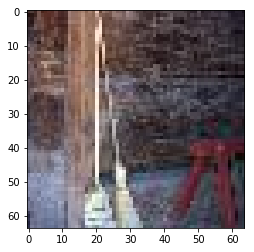

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


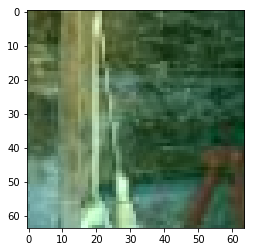

In [39]:
images, labels = trainset[:64]
plt.imshow(images[0])
plt.show()
batch_x = random_crop(images)
batch_x = random_flip_left_right(batch_x)
batch_x = random_rgb_shift(batch_x)
plt.imshow(batch_x[0])
plt.show()

In [ ]:
num_epoch = 100
num_batch = 64

sess = net.session
for epoch in range(num_epoch):
    # Fitting Model  
    for step in tqdm(range(num_data//num_batch)):
        batch_x, batch_y = trainset.next_batch(num_batch)
        batch_x = random_crop(batch_x)
        batch_x = random_flip_left_right(batch_x)
        batch_x = random_rgb_shift(batch_x)
        sess.run(train_op,feed_dict={
            x:batch_x,labels:batch_y,
            is_train:True,lr: 0.001})

    # Summarize training process
    sess.run(metric_init_op)
    for step in range(0,len(trainset)//100,10):
        train_x, train_y = trainset[step*100:(step+1)*100]
        sess.run(metric_update_op,feed_dict={x:train_x,labels:train_y})
    summary, top_1_value,top_5_value = sess.run([merged,top_1,top_5], 
                                                feed_dict={x:train_x,
                                                           labels:train_y})
    
    print("[{:3d} epoch] TRAIN TOP-1 ACC : {:2.2f}% | TOP-5 ACC : {:2.2f}%"
          .format(epoch, top_1_value,top_5_value))
    train_writer.add_summary(summary, global_step.eval(sess))

    sess.run(metric_init_op)
    for step in range(len(validset)//100):
        valid_x, valid_y = validset[step*100:(step+1)*100]
        sess.run(metric_update_op,feed_dict={x:valid_x,labels:valid_y})
    summary, top_1_value,top_5_value = sess.run([merged,top_1,top_5], 
                                                feed_dict={x:valid_x,
                                                           labels:valid_y})
    print("[{:3d} epoch] VALID TOP-1 ACC : {:2.2f}% | TOP-5 ACC : {:2.2f}%"
          .format(epoch, top_1_value,top_5_value))
    test_writer.add_summary(summary, global_step.eval(sess))